# Apache Kafka Streaming Analytics
### One Broker Setup
<br>
<hr>

#### Component: Producer
In this notebook Apache Kafka is going to be used and analyzed with reference to the streaming performance using the twitter dataset.

In this case, we are going to use only one **Kafka Broker** that streams the data to the **Kafka Consumer**.

In [ ]:
# Install the Python Client for Apache Kafka
!pip install confluent-kafka

In [1]:
# Load dependencies and set constants
from confluent_kafka import Producer
from time import time, perf_counter

import matplotlib.pyplot as plt

# DATA_GENERATION_IN_MB = 1000 # ~ 1GB
DATA_GENERATION_IN_MB = 100 # For Testing

DATASET_SIZE_IN_MB = 10
DATASET_SIZE_IN_MSGS = 14485

TWITTER_DATA_PATH = "/home/ubuntu/Stream-Analytics/data/dataset.json"
KAFKA_TOPIC_TWITTER = "twitter-stream"


def producer_stats(start: int, end: int, data_size: int):
    """
    Evaluates the throughput for the producer.
    :param start: the UTC time in milliseconds (time since epoch)
    :param end: the UTC time in milliseconds (time since epoch)
    :param data_size: size of produced data in MB
    """
    delta_seconds = float(end - start)
    throughput = data_size / delta_seconds
    
    print("Sent {0} MB in {1} seconds.".format(data_size, delta_seconds))
    print("Throughput: ~{0} MB/s | ~{1} MBit/s".format(int(throughput), int(throughput * 8)))
    

### Reminder: Running Kafka Architecture required
The following cells assume a running Apache Kafka Environment.
<hr>
<br>

Furthermore, as we are using the **Producer** component here, we have to make sure that the **Consumer** component is already running / expecting streaming data to ensure a performance measurement under realistic circumstances.

In [2]:
# Produce the data / write it to the Kafka Cluster
producer_config = {
    "bootstrap.servers": "localhost:9092",
}
p = Producer(producer_config)

In [ ]:
# This is left for testing, for benchmark see below
start = perf_counter()

# Fill the topic with the specified amount of data
generation_steps = int(DATA_GENERATION_IN_MB / DATASET_SIZE_IN_MB)
with open(TWITTER_DATA_PATH, "r") as dataset:
    for step in range(generation_steps):
        print(f"Executing data generation step {step}...")
        dataset.seek(0) # Jump back to first line  
 
        for tweet in dataset:
            try:
                # print("IN QUEUE: {}".format(len(p)))
                p.produce(KAFKA_TOPIC_TWITTER, value=tweet)
                p.poll(0)
            except BufferError:
                print('[INFO] Local producer queue is full (%d messages awaiting delivery): Trying again...\n' % len(p)) 
                p.poll(1)
        
                # Retry sending tweet
                p.produce(KAFKA_TOPIC_TWITTER, value=tweet)   
p.flush(30)

end = perf_counter()
print("Data generation done!" + "\n")

producer_stats(start, end, DATA_GENERATION_IN_MB)

In [3]:
def benchmark(data_vol:int = 1000, exec_count: int = 10):
    """ Executes a throughput benchmark procedure, e.g. the amount of MB per second that was 
        sent by the producer to the Broker. To get meaningful results, the benchmark procedure 
        is repeated exec_count times.
        Default is ~ 1GB per execution, while executing 10 times.
        
        :param: data_vol Amount of data to send per execution, given in MB. As the dataset is 10 MB large,
                         data_vol % 10 = 0 should be true for the given argument.
        :param exec_count: Amount of times to repeat the benchmark procedure
    """
    print("Executing throughput benchmark ...")

    throughputs_in_mb = [] # MB/s
    throughputs_in_msgs = [] # Messages/s
    benchmark_msg_count = int(DATASET_SIZE_IN_MSGS * (data_vol / DATASET_SIZE_IN_MB))
    data_generation_steps = int(data_vol / DATASET_SIZE_IN_MB)
    
    with open(TWITTER_DATA_PATH, "r") as dataset:
        for execution in range(exec_count):
            start = perf_counter()
            
            for step in range(data_generation_steps):
                dataset.seek(0) # Jump back to first line 
                
                for tweet in dataset:
                    try:
                        p.produce(KAFKA_TOPIC_TWITTER, value=tweet)
                        p.poll(0)
                    except BufferError:
                        print('[INFO] Local producer queue is full (%d messages awaiting delivery): Trying again...\n' % len(p)) 
                        p.poll(5)

                        # Retry sending tweet
                        p.produce(KAFKA_TOPIC_TWITTER, value=tweet)   
                        
            end = perf_counter()
            
            delta_seconds = float(end - start)
            megabytes_per_second = data_vol / delta_seconds
            msgs_per_second = int(benchmark_msg_count / delta_seconds)

            print("{} Messages in {:.2f} seconds | {} Messages/s"
              .format(benchmark_msg_count, delta_seconds, msgs_per_second))
                        
            throughputs_in_mb.append(megabytes_per_second)
            throughputs_in_msgs.append(msgs_per_second)
    p.flush(30)

    print("Benchmark procedure finished. Visualizing the results ...")
    
    # Plot MB/s results
    fig = plt.figure(figsize=(10, 6), dpi=80)
    ax = plt.axes()
    
    executions = ["Ex. {0}".format(i) for i in range(1, len(throughputs_in_mb)+1)]
    ax.bar(executions, throughputs_in_mb, width=0.4)
    
    ax.set_xlabel("Benchmark Executions", fontsize=12)
    ax.set_ylabel("Throughput (MB/s)", fontsize=12)
    ax.set_title("Benchmark: Throughput ({} MB)".format(data_vol))
    plt.show()
    
    # Plot Messages/s results
    fig = plt.figure(figsize=(10, 6), dpi=80)
    ax = plt.axes()
    
    ax.bar(executions, throughputs_in_msgs, width=0.4)
    
    ax.set_xlabel("Benchmark Executions", fontsize=12)
    ax.set_ylabel("Throughput (Messages/s)", fontsize=12)
    ax.set_title("Benchmark: Throughput ({} Messages)".format(benchmark_msg_count))
    
    plt.show()

Executing throughput benchmark ...
1448500 Messages in 10.39 seconds | 139463 Messages/s
[INFO] Local producer queue is full (100000 messages awaiting delivery): Trying again...

1448500 Messages in 10.27 seconds | 141063 Messages/s
1448500 Messages in 9.68 seconds | 149685 Messages/s
1448500 Messages in 9.06 seconds | 159841 Messages/s
1448500 Messages in 9.98 seconds | 145181 Messages/s
Benchmark procedure finished. Visualizing the results ...


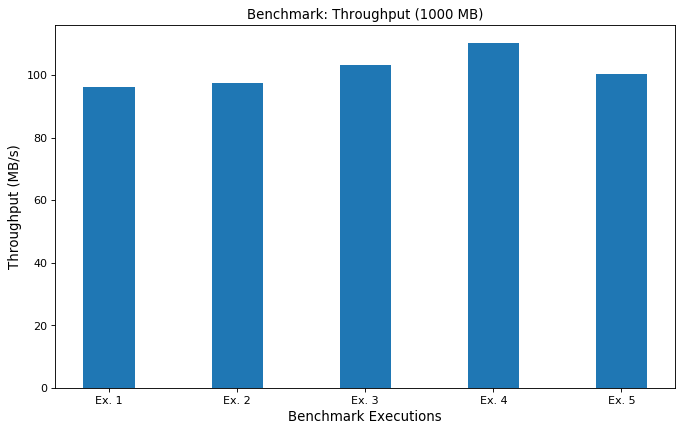

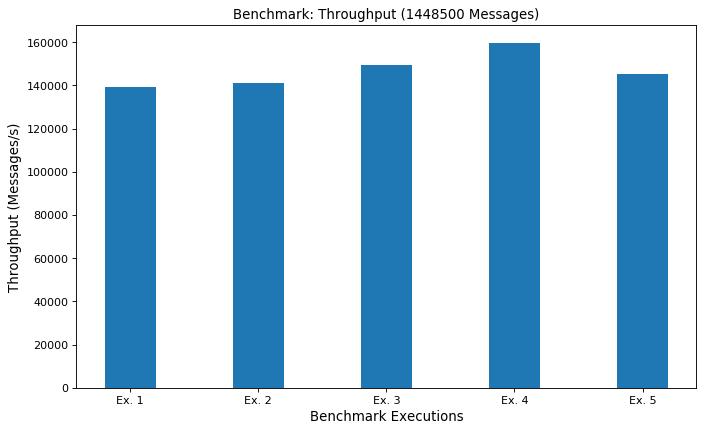

In [5]:
# Execute the benchmark
benchmark(data_vol=1000, exec_count=5)